In [143]:
from pathlib import Path
from typing import List

import pydicom

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from kedro.extras.datasets.pickle import PickleDataSet
from kedro.config import ConfigLoader

import kornia.augmentation as K
import plotly.express as px

from PIL import Image

import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.utils import save_image
from torchvision import transforms

In [4]:
import os, sys
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src/'))

from src.tagseg.data.acdc_dataset import AcdcDataSet
from src.tagseg.data.dmd_dataset import DmdDataSet, DmdTimeDataSet, Slice
from src.tagseg.data.scd_dataset import ScdDataSet
from src.tagseg.pipelines.data_processing.nodes import preprocess_acdc
from src.tagseg.pipelines.data_splitting.nodes import split_data

In [5]:
conf_paths = ["../conf/base", "../conf/local"]
conf_loader = ConfigLoader(conf_paths)
conf_catalog = conf_loader.get("catalog*", "catalog*/**")

In [79]:
storage = []

base_path = Path('../data/01_raw/dmd_org2/')

groups = [gr for gr in base_path.iterdir() if gr.is_dir()]
for group in groups:

    treatments = [tr for tr in group.iterdir() if tr.is_dir()]
    for treatment in treatments:

        if treatment.stem == 'DMD':
            directories = [di for di in treatment.iterdir() if di.is_dir()]
        else:
            directories = [treatment]    
        
        for directory in directories:

            centers = [ce for ce in directory.iterdir() if ce.is_dir()]
            for center in centers:

                patients = [pa for pa in center.iterdir() if pa.is_dir()]
                for patient in patients:

                    slices = [mo for mo in patient.iterdir() if mo.is_dir()]
                    for slic in slices:

                        scans = [s for s in slic.iterdir() if s.is_dir()]
                        for scan in scans:
                            
                            not_dcm = [f for f in scan.iterdir() if f.is_file() and f.suffix != ".dcm"]
                            
                            if len(not_dcm) > 0:
                                print(not_dcm)

                            # cine or tag
                            study_info = scan.name.split('_')
                            modality = study_info[0]

                            element = dict(
                                group=group.stem,
                                treatment=treatment.stem,
                                center=center.stem,
                                patient=patient.stem,
                                slice=slic.stem,
                                modality=modality,
                                m=study_info[1][1:] if modality == 'cine' else np.nan,
                                dz=study_info[2][2:] if modality == 'cine' else np.nan,
                                study_no=study_info[-1],
                                path=scan,
                                annotated=(scan / 'roi_pts.npz').exists(),
                                timepoints=len([f for f in scan.iterdir() if f.is_file() and f.suffix == ".dcm"])
                            )

                            storage.append(element)

In [80]:
df = pd.DataFrame(storage)
df.dz = df.dz.astype(np.float32)

In [81]:
train_ids, _ = train_test_split(df.patient.unique(), test_size=0.15, shuffle=False)

In [82]:
df['set'] = df.patient.apply(lambda patient_id: 'train' if patient_id in train_ids else 'test')

In [98]:
# keep all tagged data
df['keep'] = df.modality == 'tag'

# choose best according cine for each patient slice
for (patient, slice), group in df.groupby(['patient', 'slice']):

    sorted_cines = group[(group.modality == 'cine') & (group.timepoints.isin([25, 30]))] \
        .sort_values(['m', 'dz', 'study_no'], ascending=[True, True, False])

    if len(sorted_cines) > 0:
        best_cine = sorted_cines.iloc[0].name
        df.loc[best_cine, 'keep'] = True

In [118]:
df.tail(10)

,group,treatment,center,patient,slice,modality,m,dz,study_no,path,annotated,timepoints,set,keep
580,GROUP_2,DMD,CHOC,16-000297-303,base,cine,3,-5.54,0048,../data/01_raw/dmd_org2/GROUP_2/DMD/SCAN_1/CHO...,False,25,test,True
581,GROUP_2,DMD,CHOC,16-000297-303,base,cine,3,-5.54,0046,../data/01_raw/dmd_org2/GROUP_2/DMD/SCAN_1/CHO...,False,25,test,False
582,GROUP_2,DMD,CHOC,16-000297-303,apex,cine,3,-5.54,0051,../data/01_raw/dmd_org2/GROUP_2/DMD/SCAN_1/CHO...,False,25,test,True
583,GROUP_2,DMD,CHOC,16-000297-303,apex,tag,NaN,NaN,0012,../data/01_raw/dmd_org2/GROUP_2/DMD/SCAN_1/CHO...,False,25,test,True
584,GROUP_2,DMD,CHOC,16-000297-303,apex,cine,3,4.06,0050,../data/01_raw/dmd_org2/GROUP_2/DMD/SCAN_1/CHO...,False,25,test,False
585,GROUP_2,DMD,CHOC,16-000297-303,mid,tag,NaN,NaN,0010,../data/01_raw/dmd_org2/GROUP_2/DMD/SCAN_1/CHO...,False,25,test,True
586,GROUP_2,DMD,CHOC,16-000297-303,mid,cine,3,4.06,0047,../data/01_raw/dmd_org2/GROUP_2/DMD/SCAN_1/CHO...,False,25,test,False
587,GROUP_2,DMD,CHOC,16-000297-303,mid,cine,3,-5.54,0049,../data/01_raw/dmd_org2/GROUP_2/DMD/SCAN_1/CHO...,False,25,test,True
588,GROUP_2,DMD,CHOC,16-000297-303,mid,cine,3,4.06,0048,../data/01_raw/dmd_org2/GROUP_2/DMD/SCAN_1/CHO...,False,25,test,False
589,GROUP_2,DMD,CHOC,16-000297-303,mid,cine,3,4.06,0046,../data/01_raw/dmd_org2/GROUP_2/DMD/SCAN_1/CHO...,False,25,test,False


In [102]:
df.to_csv('../data/02_intermediate/dmd_index.csv')

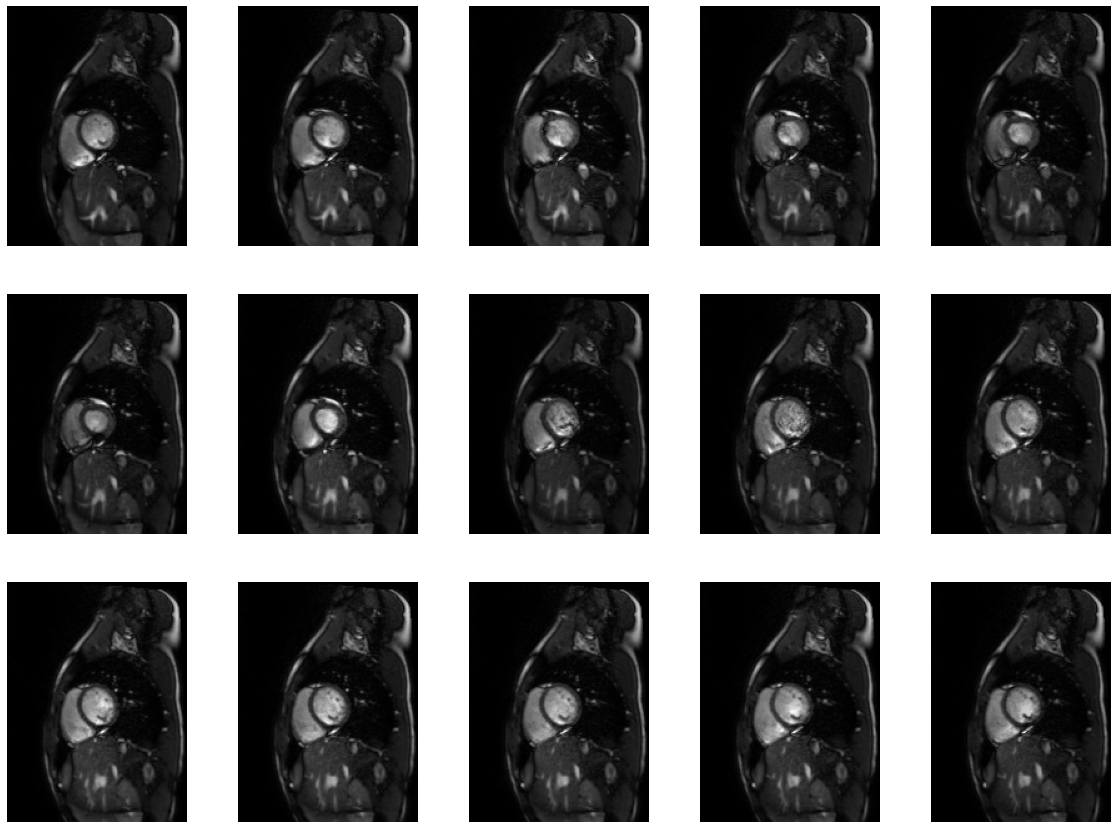

In [12]:
path = df.loc[58].path

dcm_images = [f for f in path.iterdir() if f.is_file() and f.suffix == ".dcm"]
if len(dcm_images) > 0:
    res = map(
        lambda ds: (ds.InstanceNumber, ds.pixel_array),
        map(pydicom.dcmread, dcm_images),
    )
    image = np.array(list(zip(*sorted(res, key=lambda item: item[0])))[1])

rows = 5
cols = image.shape[0] // rows
if image.shape[0] % rows > 0:
    cols += 1

cols = 3
fig, ax = plt.subplots(cols, rows, figsize=(20, 15))

for i in range(image.shape[0])[:15]:
    ax[i // rows, i % rows].imshow(image[i], cmap='gray')
    ax[i // rows, i % rows].axis('off')

Save it for GAN to process

In [115]:
tr_A = df[(df.set == 'train') & (df.keep) & (df.modality == 'cine')].timepoints.sum()
tr_B = df[(df.set == 'train') & (df.keep) & (df.modality == 'tag')].timepoints.sum()
te_A = df[(df.set == 'test') & (df.keep) & (df.modality == 'cine')].timepoints.sum()
te_B = df[(df.set == 'test') & (df.keep) & (df.modality == 'tag')].timepoints.sum()

print('\t \t Train \t Test')
print(f'A (cine) \t {tr_A} \t {te_A}')
print(f'B (tag) \t {tr_B} \t {te_B}')

	 	 Train 	 Test
A (cine) 	 2440 	 585
B (tag) 	 4539 	 706


In [173]:
!rm -rf ../data/05_model_input/taggedmr-dmd/

In [174]:
base_path = Path('../data/05_model_input/taggedmr-dmd/')

base_path.mkdir()
(base_path / 'train').mkdir()
(base_path / 'train' / 'A').mkdir()
(base_path / 'train' / 'B').mkdir()
(base_path / 'test').mkdir()
(base_path / 'test' / 'A').mkdir()
(base_path / 'test' / 'B').mkdir()

In [175]:
preprocess = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=0.456, std=0.224),
        transforms.Resize((256, 256)),
    ]
)

In [176]:
group = dict(cine='A', tag='B')

for _, row in df.iterrows():

    if row.keep:
        save_path = base_path / row.set / group.get(row.modality)
        identifier = '_'.join([row.group, row.treatment, row.center, row.patient, row.slice, row.modality, row.study_no])

        dcm_images = [f for f in row.path.iterdir() if f.is_file() and f.suffix == ".dcm"]
        
        if len(dcm_images) > 0:
            res = map(
                lambda ds: (ds.InstanceNumber, ds.pixel_array),
                map(pydicom.dcmread, dcm_images),
            )
            images = np.array(list(zip(*sorted(res, key=lambda item: item[0])))[1])

        for no, img in enumerate(images):
            
            img = img.astype(np.float64)
            img = preprocess(img)

            scale = abs(img.min() - img.max())
            img = (img - img.min()) / scale

            save_image(img, save_path / f'img_{identifier}_{no}.png')

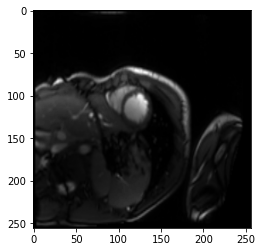

In [177]:
im = Image.open('../data/05_model_input/taggedmr-dmd/train/A/img_GROUP_1_CONTROL_UCLA_16-000297-001_apex_cine_120_0.png').convert('L')

plt.imshow(im, cmap='gray') 